In [2]:
# ВНИМАНИЕ; версия Pillow установвленна по умолчанию - '7.0.0'
# Эта версия ломает torchvision
import PIL
PIL.__version__

'5.3.0'

In [ ]:

!pip uninstall -y Pillow
!pip install -Iv Pillow==5.3.0

---


**ВНИМАНИЕ: На этом этапе обязательно перезагрузить рантайм (Runtime -> Restart Runtime). Иначе версия 5.3.0 не будет загружена в рантайм.**

После перезапуска рантайма следует продолжить исполнять ячейки далее.

---



## **Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ**

# Путешествие по Спрингфилду.


Сегодня вам предстоить помочь телекомпании FOX  в обработке их контента. Как вы знаете сериал Симсоны идет на телеэкранах более 25 лет и за это время скопилось очень много видео материала. Персоонажи менялись вместе с изменяющимися графическими технологиями   и Гомер 2018 не очень похож на Гомера 1989. Нашей задачей будет научиться классифицировать персонажей проживающих в Спрингфилде. Думаю, что нет смысла представлять каждого из них в отдельности.



 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)



### Установка зависимостей

In [ ]:
!pip install -U torch torchvision

In [ ]:
# ИСПРАВЛЕНИЕ: к сожалению этот код не работает у меня на коллабе
# плюс что-то намудрено с именами в репозитории pytorch
  
# установка подходящей версии torch

#from os.path import exists
#from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
#platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
#cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
#accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.5.0%2B{platform}-linux_x86_64.whl torchvision
#import torch

In [ ]:
# ИСПРАВЛЕНИЕ:
# Вручную ищем и устанавливаем подходящуюю версию 
# https://download.pytorch.org/whl/torch_stable.html 
!pip install -q 'https://download.pytorch.org/whl/cu101/torch-1.5.0%2Bcu101-cp36-cp36m-linux_x86_64.whl' torchvision
import torch

In [3]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [38]:
# ВНИМАНИЕ: мы это уже сделали вначале ноутбука

# нам необходима версия pillow  5.3.0
# удалим старую версию и установим новую
#!pip uninstall -y Pillow
#!pip install Pillow==5.3.0
#import PIL
#print(PIL.PILLOW_VERSION)
# здесь должна быть версия 5.3.0. если это не так перехгрузите данный ноутбук:
# Menu > Runtime > Restart Runtime

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')



---

**ВНИМАНИЕ: скачайте датасет с каггла и положите его в корень своего гугл диска!**

---



In [ ]:
# ИСПРАВЛЕНИЕ
#!unzip -q /content/gdrive/My\ Drive/simpsons/data/dataset.zip -d train
#!unzip -q /content/gdrive/My\ Drive/simpsons/data/testset.zip -d test

# !unzip -q /content/gdrive/My\ Drive/journey-springfield.zip

In [ ]:
!ls train

In [4]:
!nvidia-smi
import torch
torch.cuda.is_available()

Tue May  5 14:11:09 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 440.59       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce MX150       Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   52C    P0    N/A /  N/A |    516MiB /  2002MiB |     10%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [5]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


/home/philipp/anaconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


In [6]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} \\$,      константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [7]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [8]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
TRAIN_DIR = Path('/home/philipp/Projects/simpson classification/journey-springfield/train')
TEST_DIR = Path('/home/philipp/Projects/simpson classification/journey-springfield/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [10]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, stratify=train_val_labels)

In [11]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [12]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions): 
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

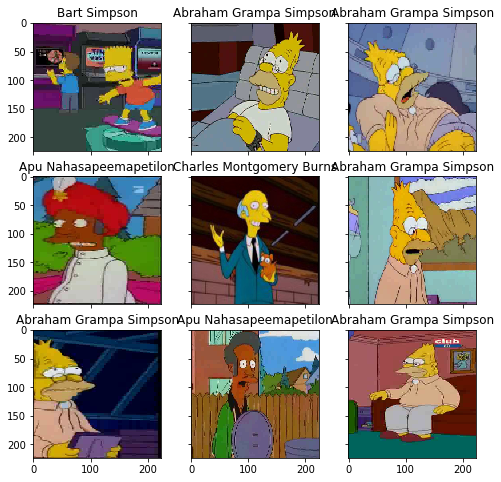

In [13]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [14]:
# Очень простая сеть
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [15]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [16]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [17]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [18]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

Запустим обучение сети.

In [ ]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=2, batch_size=64)

Построим кривые обучения

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [55]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной 
    картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [64]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [ ]:
from sklearn.metrics import f1_score

f1_score(actual_labels, preds_class)


Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [ ]:
# ДОБАВЛЕНО: создание сабмита
import pandas as pd
df = pd.DataFrame()
df['Id'] = test_filenames
df['Expected'] = preds
df.to_csv('/home/philipp/Projects/simpson classification/simple_cnn_baseline.csv', index=False)
# файл появится у вас на гугл диске

In [ ]:
! ls 

In [ ]:
# ЗДЕСЬ что-то не работает. Не понятно зачем читайют лейблы 
#import pandas as pd
#my_submit = pd.read_csv("gdrive/My Drive/simpsons/data/labels.csv")
#my_submit = pd.DataFrame({'Image_id': test_filenames, 'Expected': preds})
#my_submit.head()

In [ ]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать. 

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову: 


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)


# В данном разделе я экспериментирую и пробую разные модели и разные методы, такие как: Feature Extractor, Fine Tuning. 

Все модели будут предобученными, их я беру по причине того, что обучающая выборка мала, и только на ней не получиться получить высокую обобщающую способность. А вот предобученные модели на ImageNet самое то.

Команды, которые я нашел в какой-то статье, которые увеличивают скорость обучения, но теряется воспроизводимость:

In [19]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =  True 
torch.backends.cudnn.deterministic = False

In [20]:
from torchvision import models

In [79]:
train_dataset = SimpsonsDataset(train_files, "train")
val_dataset = SimpsonsDataset(val_files, "val")

In [25]:
n_classes = len(np.unique(train_val_labels))

Создаем предобученную модель VGG16, взятую из torchvision.models.

In [ ]:
model_vgg = models.vgg16(pretrained=True).to(DEVICE)

Посмотрим на архитектуру VGG16:

In [ ]:
model_vgg

Самым простым решением будет поменять классификатор - полносвязный слой на свой, который подойдет под количество классов в нашей выборке. Используем feature extractor, замораживаем веса остальных слоев.

In [ ]:
for param in model_vgg.features.parameters():
    param.requires_grad = False
model_vgg.classifier = nn.Linear(25088, n_classes).cuda()

Обучим модель, функцией train из 2 главы.

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [ ]:
history_vgg = train(train_dataset, val_dataset, model=model_vgg, epochs=2, batch_size=16)

Посмотрим на результат работы модели.

In [ ]:
loss, acc, val_loss, val_acc = zip(*history_vgg)

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

Данный результат не устравивает, попробуем более легкую с точки зрения потребления памяти сеть: ResNet18, так же будем обучать ся помощью Feature Extracor.

In [58]:
model_resnet = models.resnet18(pretrained=True).to(DEVICE)

In [ ]:
model_resnet

In [60]:
for param in model_resnet.parameters():
    param.requires_grad = False
model_resnet.fc.requires_grad = True
model_resnet.fc = nn.Linear(512, n_classes).cuda()

In [ ]:
history_resnet = train(train_dataset, val_dataset, model=model_vgg, epochs=2, batch_size=8)

In [ ]:
loss, acc, val_loss, val_acc = zip(*history_resnet)

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

Сохраним веса.

In [ ]:
torch.save(model_resnet.state_dict(), "/home/philipp/Projects/simpson classification/model_resnet_weights.pth") 

In [62]:
model_resnet.load_state_dict(torch.load("/home/philipp/Projects/simpson classification/model_resnet_weights.pth"))

<All keys matched successfully>

In [65]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=8)
probs = predict(model_resnet, test_loader)

# получим вектор предскзаний
preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [66]:
# ДОБАВЛЕНО: создание сабмита
import pandas as pd
df = pd.DataFrame()
df['Id'] = test_filenames
df['Expected'] = preds
df.to_csv('/home/philipp/Projects/simpson classification/model_resnet18.csv', index=False)
# файл появится у вас на гугл диске

С помощью feature extractor не удалось получить высоких результатов, поэтому обучим предобученную на ImageNet ResNet18. 

In [ ]:
model_resnet_ft = models.resnet18(pretrained=True).cuda()

Посмотрим на архитектуру сети:

In [ ]:
model_resnet_ft

Заморозим 3 секвеншл слоя и обучим на остальном, поставим свой  полносвязный слой, с количеством выходов, равным количеству классов.

In [23]:
for param in model_resnet_ft.parameters():
    param.requires_grad = False

In [26]:
model_resnet_ft.fc = nn.Linear(in_features=512, out_features=n_classes, bias=True).cuda()

In [27]:
for param in model_resnet_ft.layer4.parameters():
    param.requires_grad = True
for param in model_resnet_ft.fc.parameters():
    param.requires_grad = True

In [28]:
train_dataset = SimpsonsDataset(train_files, "train")
val_dataset = SimpsonsDataset(val_files, "val")

Обучим на 40 эпохах:

In [30]:
history_resnet_ft = train(train_dataset, val_dataset, model=model_resnet_ft, epochs=40, batch_size=64)

epoch:   0%|          | 0/40 [00:00<?, ?it/s]

loss 0.5356045578281867


epoch:   2%|▎         | 1/40 [03:18<2:08:43, 198.04s/it]


Epoch 001 train_loss: 0.5356     val_loss 0.3515 train_acc 0.8688 val_acc 0.9098
loss 0.3239117601544806


epoch:   5%|▌         | 2/40 [06:38<2:05:52, 198.76s/it]


Epoch 002 train_loss: 0.3239     val_loss 0.4015 train_acc 0.9139 val_acc 0.8942
loss 0.17766579350522918


epoch:   8%|▊         | 3/40 [09:44<2:00:14, 194.98s/it]


Epoch 003 train_loss: 0.1777     val_loss 0.3827 train_acc 0.9513 val_acc 0.9068
loss 0.10293100347786456


epoch:  10%|█         | 4/40 [12:50<1:55:21, 192.27s/it]


Epoch 004 train_loss: 0.1029     val_loss 0.2899 train_acc 0.9701 val_acc 0.9234
loss 0.08152499688723162


epoch:  12%|█▎        | 5/40 [15:56<1:51:06, 190.47s/it]


Epoch 005 train_loss: 0.0815     val_loss 0.3372 train_acc 0.9746 val_acc 0.9295
loss 0.08590642503691187


epoch:  15%|█▌        | 6/40 [19:02<1:47:09, 189.10s/it]


Epoch 006 train_loss: 0.0859     val_loss 0.3248 train_acc 0.9759 val_acc 0.9241
loss 0.0637467926919175


epoch:  18%|█▊        | 7/40 [22:08<1:43:28, 188.12s/it]


Epoch 007 train_loss: 0.0637     val_loss 0.3536 train_acc 0.9810 val_acc 0.9205
loss 0.03832728442375816


epoch:  20%|██        | 8/40 [25:14<1:40:01, 187.54s/it]


Epoch 008 train_loss: 0.0383     val_loss 0.3629 train_acc 0.9893 val_acc 0.9362
loss 0.043701479241823354


epoch:  22%|██▎       | 9/40 [28:20<1:36:39, 187.09s/it]


Epoch 009 train_loss: 0.0437     val_loss 0.3584 train_acc 0.9873 val_acc 0.9398
loss 0.050016203530133245


epoch:  25%|██▌       | 10/40 [31:26<1:33:22, 186.75s/it]


Epoch 010 train_loss: 0.0500     val_loss 0.3221 train_acc 0.9868 val_acc 0.9408
loss 0.022000058743296153


epoch:  28%|██▊       | 11/40 [34:38<1:30:57, 188.18s/it]


Epoch 011 train_loss: 0.0220     val_loss 0.3237 train_acc 0.9934 val_acc 0.9400
loss 0.06750934123394937


epoch:  30%|███       | 12/40 [37:44<1:27:32, 187.60s/it]


Epoch 012 train_loss: 0.0675     val_loss 0.3567 train_acc 0.9832 val_acc 0.9259
loss 0.028599971745065497


epoch:  32%|███▎      | 13/40 [40:50<1:24:12, 187.13s/it]


Epoch 013 train_loss: 0.0286     val_loss 0.3379 train_acc 0.9926 val_acc 0.9415
loss 0.03741305662732313


epoch:  35%|███▌      | 14/40 [43:56<1:20:58, 186.85s/it]


Epoch 014 train_loss: 0.0374     val_loss 0.5222 train_acc 0.9904 val_acc 0.9222
loss 0.05273260702833764


epoch:  38%|███▊      | 15/40 [47:02<1:17:45, 186.64s/it]


Epoch 015 train_loss: 0.0527     val_loss 0.4095 train_acc 0.9870 val_acc 0.9188
loss 0.027469683072393704


epoch:  40%|████      | 16/40 [50:09<1:14:35, 186.48s/it]


Epoch 016 train_loss: 0.0275     val_loss 0.3768 train_acc 0.9929 val_acc 0.9285
loss 0.02820651735786217


epoch:  42%|████▎     | 17/40 [53:15<1:11:25, 186.33s/it]


Epoch 017 train_loss: 0.0282     val_loss 0.8030 train_acc 0.9938 val_acc 0.8651
loss 0.030704970632862164


epoch:  45%|████▌     | 18/40 [56:20<1:08:16, 186.20s/it]


Epoch 018 train_loss: 0.0307     val_loss 0.3833 train_acc 0.9928 val_acc 0.9322
loss 0.029201545740720196


epoch:  48%|████▊     | 19/40 [59:27<1:05:10, 186.22s/it]


Epoch 019 train_loss: 0.0292     val_loss 0.3464 train_acc 0.9932 val_acc 0.9427
loss 0.027013322229187644


epoch:  50%|█████     | 20/40 [1:02:33<1:02:02, 186.11s/it]


Epoch 020 train_loss: 0.0270     val_loss 0.3924 train_acc 0.9934 val_acc 0.9371
loss 0.027863318430055423


epoch:  52%|█████▎    | 21/40 [1:05:38<58:54, 186.03s/it]  


Epoch 021 train_loss: 0.0279     val_loss 0.3218 train_acc 0.9928 val_acc 0.9469
loss 0.0028171350681042927


epoch:  55%|█████▌    | 22/40 [1:08:44<55:48, 186.02s/it]


Epoch 022 train_loss: 0.0028     val_loss 0.5033 train_acc 0.9991 val_acc 0.9190
loss 0.041323413635683044


epoch:  57%|█████▊    | 23/40 [1:11:50<52:41, 185.99s/it]


Epoch 023 train_loss: 0.0413     val_loss 0.3410 train_acc 0.9918 val_acc 0.9389
loss 0.02495782470557331


epoch:  60%|██████    | 24/40 [1:14:57<49:37, 186.07s/it]


Epoch 024 train_loss: 0.0250     val_loss 0.3384 train_acc 0.9944 val_acc 0.9448
loss 0.0464573011207485


epoch:  62%|██████▎   | 25/40 [1:18:03<46:30, 186.04s/it]


Epoch 025 train_loss: 0.0465     val_loss 0.3311 train_acc 0.9903 val_acc 0.9475
loss 0.02482017316413588


epoch:  65%|██████▌   | 26/40 [1:21:09<43:24, 186.03s/it]


Epoch 026 train_loss: 0.0248     val_loss 0.3485 train_acc 0.9943 val_acc 0.9433
loss 0.019833051275239797


epoch:  68%|██████▊   | 27/40 [1:24:15<40:19, 186.12s/it]


Epoch 027 train_loss: 0.0198     val_loss 0.3213 train_acc 0.9951 val_acc 0.9482
loss 0.024520480060989135


epoch:  70%|███████   | 28/40 [1:27:21<37:12, 186.07s/it]


Epoch 028 train_loss: 0.0245     val_loss 0.3342 train_acc 0.9941 val_acc 0.9505
loss 0.011964074911891866


epoch:  72%|███████▎  | 29/40 [1:30:27<34:08, 186.21s/it]


Epoch 029 train_loss: 0.0120     val_loss 0.3714 train_acc 0.9972 val_acc 0.9305
loss 0.05555801602599309


epoch:  75%|███████▌  | 30/40 [1:33:34<31:02, 186.22s/it]


Epoch 030 train_loss: 0.0556     val_loss 0.3576 train_acc 0.9871 val_acc 0.9391
loss 0.008473445324466762


epoch:  78%|███████▊  | 31/40 [1:36:40<27:57, 186.35s/it]


Epoch 031 train_loss: 0.0085     val_loss 0.3170 train_acc 0.9974 val_acc 0.9526
loss 0.001216783251107229


epoch:  80%|████████  | 32/40 [1:39:59<25:21, 190.14s/it]


Epoch 032 train_loss: 0.0012     val_loss 0.3374 train_acc 0.9996 val_acc 0.9534
loss 0.00026506250455460127


epoch:  82%|████████▎ | 33/40 [1:43:06<22:04, 189.16s/it]


Epoch 033 train_loss: 0.0003     val_loss 0.3212 train_acc 0.9999 val_acc 0.9559
loss 0.00011606457598065653


epoch:  85%|████████▌ | 34/40 [1:46:13<18:50, 188.39s/it]


Epoch 034 train_loss: 0.0001     val_loss 0.3211 train_acc 0.9999 val_acc 0.9562
loss 0.00014327870743222596


epoch:  88%|████████▊ | 35/40 [1:49:20<15:39, 187.93s/it]


Epoch 035 train_loss: 0.0001     val_loss 0.3221 train_acc 0.9999 val_acc 0.9562
loss 0.0001427270142210018


epoch:  90%|█████████ | 36/40 [1:52:27<12:30, 187.72s/it]


Epoch 036 train_loss: 0.0001     val_loss 0.3265 train_acc 0.9999 val_acc 0.9561
loss 0.00014581014505729098


epoch:  92%|█████████▎| 37/40 [1:55:33<09:22, 187.37s/it]


Epoch 037 train_loss: 0.0001     val_loss 0.3292 train_acc 0.9999 val_acc 0.9557
loss 0.00014011227664651038


epoch:  95%|█████████▌| 38/40 [1:58:42<06:15, 187.65s/it]


Epoch 038 train_loss: 0.0001     val_loss 0.3312 train_acc 0.9999 val_acc 0.9559
loss 0.00016082494196158868


epoch:  98%|█████████▊| 39/40 [2:01:57<03:09, 189.95s/it]


Epoch 039 train_loss: 0.0002     val_loss 0.3307 train_acc 0.9999 val_acc 0.9551
loss 0.00012285071229074392


epoch: 100%|██████████| 40/40 [2:05:04<00:00, 187.61s/it]


Epoch 040 train_loss: 0.0001     val_loss 0.3398 train_acc 0.9999 val_acc 0.9555


Сохраним веса, чтобы не потерять полученный результат.

In [31]:
torch.save(model_resnet_ft.state_dict(), "/home/philipp/Projects/simpson classification/model_resnetft__weights.pth") 

Изобразим результат.

In [32]:
loss, acc, val_loss, val_acc = zip(*history_resnet_ft)

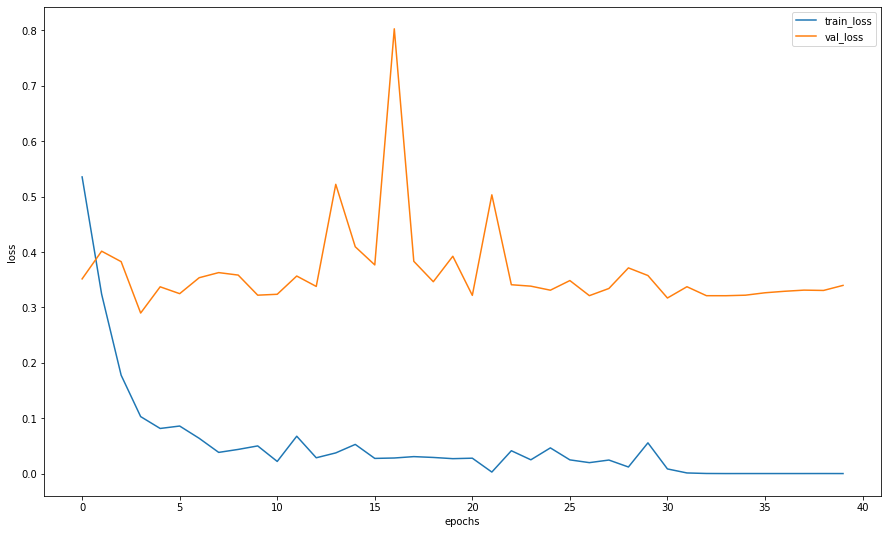

In [33]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

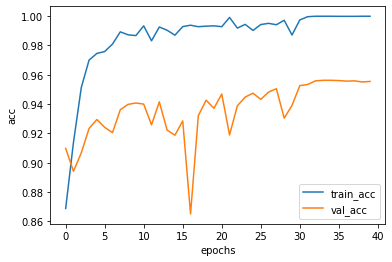

In [34]:
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

Сабмит на kaggle:

In [37]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=8)
probs = predict(model_resnet_ft, test_loader)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [38]:
# ДОБАВЛЕНО: создание сабмита
import pandas as pd
df = pd.DataFrame()
df['Id'] = test_filenames
df['Expected'] = preds
df.to_csv('/home/philipp/Projects/simpson classification/model_resnet18_ft.csv', index=False)
# файл появится у вас на гугл диске

In [54]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной 
    картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [55]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model_resnet_ft, ex_img.unsqueeze(0))

In [56]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model_resnet_ft, imgs)

In [57]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [58]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

findfont: Font family ['fantasy'] not found. Falling back to DejaVu Sans.


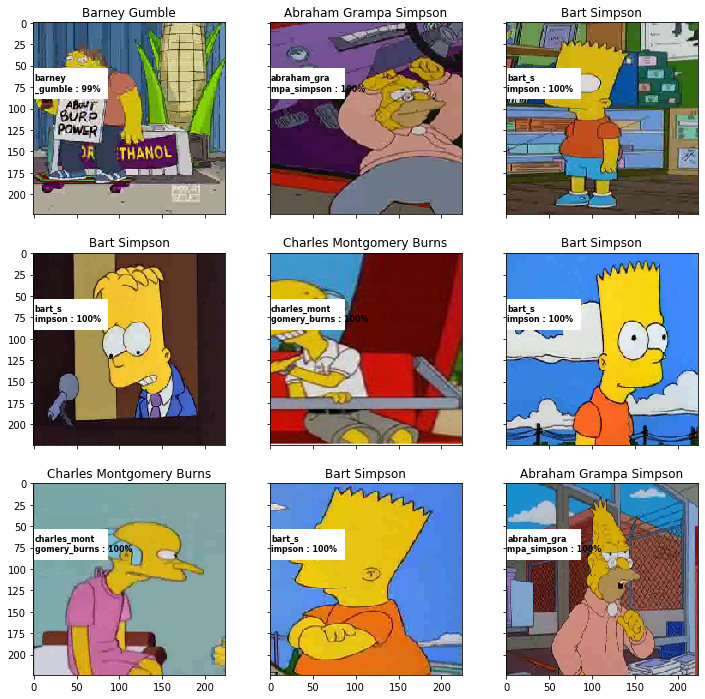

In [61]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model_resnet_ft, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')